# Integrated NER Functionality

Named Entity Recognition (NER) is a natural language processing (NLP) technique used to identify and classify specific entities in a text, such as names of people, organizations, locations, dates, and other proper nouns. The process involves tagging these entities with predefined categories, enabling machines to better understand and analyse textual data. 

NER can be used in bias identification and mitigation by detecting and categorizing references to specific demographic groups, such as gender, ethnicity, or nationality, within text data. By analyzing the frequency and context in which these entities appear, NER helps identify patterns of bias, such as underrepresentation or stereotypical portrayals. This information can then be used to adjust content or algorithms, thus ensuring more balanced and fair treatment of different groupss.

We integrated a basic NER functionality into FAID to allow developers conduct a simple analysis in the same workflow. The output of the experiments are also compatible with the popular NER libraries such as spacy, so that developers can further use the outputs in future experiments.

In [2]:
import pandas as pd

# In this experiment, we will use the credit prompts dataset, which includes German Credit data in a prompt-based format.
credit_data = pd.read_csv('data/credit_prompts_augmented.csv')
credit_data.head()

,Prompt,Risk
0,"Using the following characteristics, assess wh...",good
1,"Using the following characteristics, assess wh...",bad
2,"Using the following characteristics, assess wh...",good
3,"Using the following characteristics, assess wh...",good
4,"Using the following characteristics, assess wh...",bad


In [ ]:
import sys
sys.path.append('../../')
from faid import logging as faidlog
faidlog.init_log()

In [12]:
from faid.eval.ner.finetune import generate_training_test_data, train_ner_model

In [13]:
# We created some training and test data from the credit prompts dataset.
# You can use your own annotation using https://tecoholic.github.io/ner-annotator/
training_data, test_data = generate_training_test_data('./data/annotation/annotations.json')
training_data[0]

100%|██████████| 2/2 [00:00<00:00, 40.27it/s]

Training and testing data generated successfully. The files are saved to 'data/annotation'.


['Using the following characteristics, assess whether or not the person is a good or bad credit risk. The person is a 35 year old male. Their ethnicity is hispanic. Their marital status is married. Their job category is 3. They rent their house. They have a moderate amount in their checking account. They have little savings. They are asking for a credit amount of £6948 over a period of 36 months for the purpose of car. Answer only using "good" or "bad".',
 {'entities': [[114, 127, 'AGE'],
   [128, 133, 'GENDER'],
   [140, 162, 'ETHNICITY'],
   [169, 195, 'MARTIAL STATUS']]}]

In [ ]:
# %% Start training the model
custom_model = train_ner_model('./data/annotation/train_data.spacy', './data/annotation/model-custom', n_iter=25)

# %% Test the model
for text, _ in test_data:
    doc = custom_model(text)
    print('Entities', [(ent.text, ent.label_) for ent in doc.ents])
    print('Tokens', [(t.text, t.ent_type_, t.ent_iob) for t in doc])

In [3]:
from faid.eval.ner.detect import display_annotated_text_visual
display_annotated_text_visual(credit_data['Prompt'][0], model_path='./data/annotation/model-custom')

In [4]:
# Now, we can use the trained model to detect entities in the credit prompts dataset.
# Then, we can use the detected entities to create a tabular dataset and further use in a fairness library such as AI Fairness 360, fairlearn, or aequitas.

from faid.eval.ner.detect import get_annotated_text
print(get_annotated_text(credit_data['Prompt'][0], model_path='./data/annotation/model-custom'))

[('a 67 year old', 'AGE'), ('male.', 'GENDER'), ('ethnicity is white.', 'ETHNICITY')]


In [10]:
# Let's save this annotated data in tabular format as a new dataframe.
data = credit_data['Prompt'].apply(lambda x: get_annotated_text(x, model_path='./data/annotation/model-custom'))
print(data[0])

[('a 67 year old', 'AGE'), ('male.', 'GENDER'), ('ethnicity is white.', 'ETHNICITY')]


In [24]:
# After you get the values it might require a simple transformation to convert it into a tabular format.
import re
extracted_data = []
for row in data:
    row_dict = {}
    for item in row:
        key = item[1]
        value = item[0]
        if key == 'AGE':
            # Extract the number from the age string
            age_number = re.findall(r'\d+', value)
            row_dict[key] = int(age_number[0]) if age_number else None
        elif key == 'ETHNICITY':
            # Remove "ethnicity is" from the ethnicity string
            cleaned_ethnicity = value.replace('ethnicity is ', '').strip()
            row_dict[key] = cleaned_ethnicity
        else:
            row_dict[key] = value
    extracted_data.append(row_dict)

df = pd.DataFrame(extracted_data)

df.head()

,AGE,GENDER,ETHNICITY
0,67,male.,white.
1,22,female.,other.
2,49,male.,other.
3,45,male.,hispanic.
4,53,male.,black.


In [25]:
df["score"] = credit_data["Risk"]
# make score binary 0, 1
df["score"] = df["score"].apply(lambda x: 1 if x == "good" else 0)
# and generate a synthetic label like a prediction model
df["label"] = df["score"].sample(frac=1).reset_index(drop=True)

In [26]:
# make 'AGE', 'GENDER', 'ETHNICITY' columns categorical
df['AGE'] = df['AGE'].astype('category')
df['GENDER'] = df['GENDER'].astype('category')
df['ETHNICITY'] = df['ETHNICITY'].astype('category')

In [28]:
df.dtypes

AGE          category
GENDER       category
ETHNICITY    category
score           int64
label           int64
dtype: object

Now, we can use this tabular data in any fairness library such as fairlearn. Let's say, display the fraction based on ethnicity.

/Users/asabuncuoglu/Documents/faid/.venv/lib/python3.10/site-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
/Users/asabuncuoglu/Documents/faid/.venv/lib/python3.10/site-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
/Users/asabuncuoglu/Documents/faid/.venv/lib/python3.10/site-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)


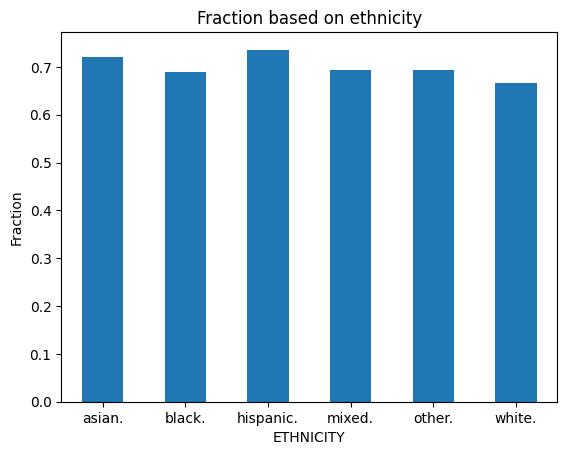

In [31]:
from fairlearn.metrics import MetricFrame, selection_rate

selection_rates = MetricFrame(
    metrics=selection_rate, y_true=df["label"], y_pred=df["score"], sensitive_features=df["ETHNICITY"]
)

fig = selection_rates.by_group.plot.bar(
    legend=False, rot=0, title="Fraction based on ethnicity", ylabel="Fraction", xlabel="ETHNICITY"
)

In [35]:
# Or, use torch group fairness metrics
import torch
from torchmetrics.classification import BinaryFairness
target = torch.tensor(df["label"])
preds = torch.tensor(df["score"])
groups = torch.tensor(df["GENDER"].cat.codes.astype("long"))
metric = BinaryFairness(2)
metric(preds, target, groups)

{'DP_0_1': tensor(0.8966), 'EO_0_1': tensor(0.9151)}

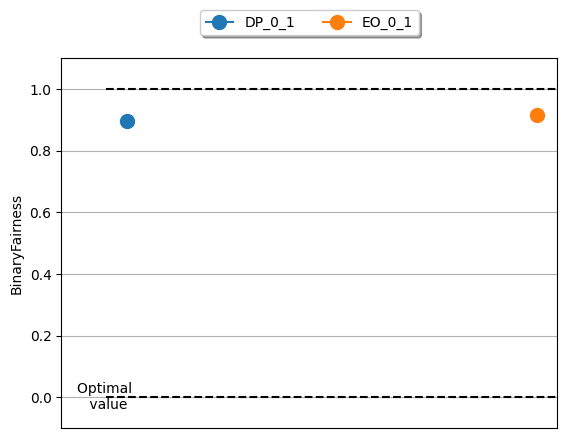

In [36]:
fig_, ax_ = metric.plot()

### Generalising the NER use with a word list

We can also use a word list to train a custom model if you do not have an annotation document. We will use [US Department of Labor's Ableist Language Detector](https://github.com/USDepartmentofLabor/ableist-language-detector) in this example. Our implemantition in the library is also very similar to their detection sample, so you can check their repository as a reference implementation.

In [1]:
WORDLIST_CSV_PATH = "data/ableist_word_list.csv"

ableist_words_df = pd.read_csv(WORDLIST_CSV_PATH)
ableist_words_df.head()

,word,dependent,dependencies,alternative_words,example
0,climb,False,NaN,"ascend, raise, work atop",Ascend a ladder to work atop roofs of customers
1,touch,False,NaN,"activate, inspect, diagnose",Inspect the thickness of clothing material
2,feel,False,NaN,"activate, inspect, diagnose",Inspect the thickness of clothing material
3,hand,False,NaN,"move, install, operate, manage, put, place, tr...",Transport boxes from shipping dock to truck
4,carry,False,NaN,"move, install, operate, manage, put, place, tr...",Transport boxes from shipping dock to truck


A biased language includes five main attributes:
1. The biased word as string
2. A boolean to check if the word has any dependencies
3. A set of dependencies
4. Alternative words that can refer to same biased words
5. An example sentence

Using this CSV format the BiasedLanguage data structure can automatically generate the representation. In this example, it is ableist words.

In [2]:
from csv import DictReader
from faid.eval.ner.detect import BiasedLanguage

ABLEIST_VERBS = {}
with open(WORDLIST_CSV_PATH, "r") as wordlist_csv:
    reader = DictReader(wordlist_csv)
    for row in reader:
        row_data = BiasedLanguage(**row)
        ABLEIST_VERBS[row_data.word] = row_data

In [3]:
print(ABLEIST_VERBS)

{'climb': BiasedLanguage(word='climb', dependent=False, alternative_words=['ascend', 'raise', 'work atop'], example='Ascend a ladder to work atop roofs of customers', dependencies=None), 'touch': BiasedLanguage(word='touch', dependent=False, alternative_words=['activate', 'inspect', 'diagnose'], example='Inspect the thickness of clothing material', dependencies=None), 'feel': BiasedLanguage(word='feel', dependent=False, alternative_words=['activate', 'inspect', 'diagnose'], example='Inspect the thickness of clothing material', dependencies=None), 'hand': BiasedLanguage(word='hand', dependent=False, alternative_words=['move', 'install', 'operate', 'manage', 'put', 'place', 'transfer', 'transport'], example='Transport boxes from shipping dock to truck', dependencies=None), 'carry': BiasedLanguage(word='carry', dependent=False, alternative_words=['move', 'install', 'operate', 'manage', 'put', 'place', 'transfer', 'transport'], example='Transport boxes from shipping dock to truck', depende

In [4]:
# This functionality is also available inside the FAID library
from faid.eval.ner.detect import get_biased_words
biased_words = get_biased_words(WORDLIST_CSV_PATH)
print(biased_words)

{'climb': BiasedLanguage(word='climb', dependent=False, alternative_words=['ascend', 'raise', 'work atop'], example='Ascend a ladder to work atop roofs of customers', dependencies=None), 'touch': BiasedLanguage(word='touch', dependent=False, alternative_words=['activate', 'inspect', 'diagnose'], example='Inspect the thickness of clothing material', dependencies=None), 'feel': BiasedLanguage(word='feel', dependent=False, alternative_words=['activate', 'inspect', 'diagnose'], example='Inspect the thickness of clothing material', dependencies=None), 'hand': BiasedLanguage(word='hand', dependent=False, alternative_words=['move', 'install', 'operate', 'manage', 'put', 'place', 'transfer', 'transport'], example='Transport boxes from shipping dock to truck', dependencies=None), 'carry': BiasedLanguage(word='carry', dependent=False, alternative_words=['move', 'install', 'operate', 'manage', 'put', 'place', 'transfer', 'transport'], example='Transport boxes from shipping dock to truck', depende

In [5]:
from faid.eval.ner.detect import find_biased_language
JOB_DESCRIPTION_FILE = "data/sample_job_descriptions/short_job_description.txt"
with open(JOB_DESCRIPTION_FILE, "r") as jd_file:
        job_description_text = jd_file.read()

result = find_biased_language(job_description_text, WORDLIST_CSV_PATH)
print(f"Found {len(result)} instances of ableist language.\n")
if len(result) > 0:
    for i, ableist_term in enumerate(result):
        print(
            f"Match #{i+1}\n"
            f"PHRASE: {ableist_term} | LEMMA: {ableist_term.lemma} | "
            f"POSITION: {ableist_term.start}:{ableist_term.end} | "
            f"ALTERNATIVES: {ableist_term.data.alternative_words} | "
            f"EXAMPLE: {ableist_term.data.example}\n"
        )

Found 4 instances of ableist language.

Match #1
PHRASE: lifting | LEMMA: lift | POSITION: 21:22 | ALTERNATIVES: ['move', 'install', 'operate', 'manage', 'put', 'place', 'transfer', 'transport'] | EXAMPLE: Transport boxes from shipping dock to truck

Match #2
PHRASE: bend | LEMMA: bend | POSITION: 37:38 | ALTERNATIVES: ['lower oneself', 'drop', 'move to', 'turn'] | EXAMPLE: Install new ethernet cables under floor rugs

Match #3
PHRASE: move your hands | LEMMA: move your hand | POSITION: 7:10 | ALTERNATIVES: ['observe', 'operate', 'transport', 'transfer', 'activate'] | EXAMPLE: Operates a machine using a lever

Match #4
PHRASE: move your wrists | LEMMA: move your wrist | POSITION: 31:34 | ALTERNATIVES: ['observe', 'operate', 'transport', 'transfer', 'activate'] | EXAMPLE: Operates a machine using a lever



In [6]:
JOB_DESCRIPTION_FILE = "data/sample_job_descriptions/long_job_description.txt"
with open(JOB_DESCRIPTION_FILE, "r") as jd_file:
        job_description_text = jd_file.read()

result = find_biased_language(job_description_text, WORDLIST_CSV_PATH)
print(f"Found {len(result)} instances of ableist language.\n")
if len(result) > 0:
    for i, ableist_term in enumerate(result):
        print(
            f"Match #{i+1}\n"
            f"PHRASE: {ableist_term} | LEMMA: {ableist_term.lemma} | "
            f"POSITION: {ableist_term.start}:{ableist_term.end} | "
            f"ALTERNATIVES: {ableist_term.data.alternative_words} | "
            f"EXAMPLE: {ableist_term.data.example}\n"
        )

Found 8 instances of ableist language.

Match #1
PHRASE: run | LEMMA: run | POSITION: 562:563 | ALTERNATIVES: ['move to', 'move about', 'traverse'] | EXAMPLE: Moves about the office regularly to meet with staff

Match #2
PHRASE: read | LEMMA: read | POSITION: 600:601 | ALTERNATIVES: ['assess', 'comprehend', 'discover', 'distinguish', 'detect', 'evaluate', 'find', 'identify', 'interpret', 'observe', 'recognize', 'understand'] | EXAMPLE: Detect errors in submitted forms

Match #3
PHRASE: lifting | LEMMA: lift | POSITION: 713:714 | ALTERNATIVES: ['move', 'install', 'operate', 'manage', 'put', 'place', 'transfer', 'transport'] | EXAMPLE: Transport boxes from shipping dock to truck

Match #4
PHRASE: carrying | LEMMA: carry | POSITION: 715:716 | ALTERNATIVES: ['move', 'install', 'operate', 'manage', 'put', 'place', 'transfer', 'transport'] | EXAMPLE: Transport boxes from shipping dock to truck

Match #5
PHRASE: lifting | LEMMA: lift | POSITION: 720:721 | ALTERNATIVES: ['move', 'install', 'op